___
# Caso de aprendizaje supervisado: Problema de clasificaci√≥n 

___
## Problema de absentismo en el trabajo

El departamento de recursos humanos de una empresa ha analizado los datos de sus empleados y ha descubierto que existe un problema con el absentismo. Han recabado datos y quieren realizar un modelo que clasifique correctamente a los empleados en funci√≥n de si faltan m√°s de 4 horas al mes o no. Esto les ser√° de utilidad de cara a realizar futuras contrataciones, e incluso hacer un seguimiento a sus empleados actuales.

Los datos para la realizaci√≥n de este problema provienen de la University of California Irvine. M√°s detalles en la siguiente url: https://archive.ics.uci.edu/ml/datasets/Absenteeism+at+work

Desc√°rgate el fichero Absenteeism_at_work.csv del campus.

## Carga de librer√≠as:

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, sys
import sklearn as skl
pd.options.display.max_columns = 500

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from IPython.display import display, HTML
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## Definici√≥n de funciones:

In [26]:
def relaciones_vs_target(X, Y, return_type='axes'):
    fig_tot = (len(X.columns))
    fig_por_fila = int(4.)
    tamanio_fig = 4.
    num_filas = int( np.ceil(fig_tot/fig_por_fila) )    
    plt.figure( figsize=( fig_por_fila*tamanio_fig+5, num_filas*tamanio_fig+5 ) )
    c = 0 
    for i, col in enumerate(X.columns):
        plt.subplot(num_filas, fig_por_fila, i+1)
        sns.scatterplot(x=X[col], y=Y)
        plt.title( '%s vs %s' % (col, 'target') )
        plt.ylabel('Target')
        plt.xlabel(col)
    plt.show()

def represento_doble_hist(pos_values, neg_values, nbins, density, title):
    """Plots two histograms (positive and negative class) in the same figure."""
    plt.hist(pos_values, bins=nbins, alpha=0.5, color='blue', label='Positive', density=density)
    plt.hist(neg_values, bins=nbins, alpha=0.5, color='red', label='Negative', density=density)
    plt.title(title)
    plt.legend()

def hist_pos_neg_feat(x, y, normed=False, nbins=11, targets=(0,1)):
    """Plots histograms of features split by target class."""
    fig_tot = len(x.columns)
    fig_tot_fila = 4
    fig_tamanio = 4
    num_filas = int(np.ceil(fig_tot / fig_tot_fila))
    
    plt.figure(figsize=(fig_tot_fila * fig_tamanio + 2, num_filas * fig_tamanio + 2))
    
    target_neg, target_pos = targets
    for i, feat in enumerate(x.columns):
        plt.subplot(num_filas, fig_tot_fila, i+1)
        plt.title(feat)
        idx_pos = y == target_pos
        idx_neg = y == target_neg
        represento_doble_hist(
            x[feat][idx_pos].values, x[feat][idx_neg].values, 
            nbins, density=bool(normed), title=feat
        )

    plt.tight_layout()
    plt.show()

## Carga de datos:

In [5]:
XY = pd.read_csv('./Absenteeism_at_work.csv', sep=';', index_col=False)

In [6]:
XY[:2]

ID  Reason for absence  Month of absence  Day of the week  Seasons  \
0  11                  26                 7                3        1   
1  36                   0                 7                3        1   

   Transportation expense  Distance from Residence to Work  Service time  Age  \
0                     289                               36            13   33   
1                     118                               13            18   50   

   Work load Average/day   Hit target  Disciplinary failure  Education  Son  \
0                 239.554          97                     0          1    2   
1                 239.554          97                     1          1    1   

   Social drinker  Social smoker  Pet  Weight  Height  Body mass index  \
0               1              0    1      90     172               30   
1               1              0    0      98     178               31   

   Absenteeism time in hours  
0                          4  
1                          0

In [7]:
print('- El n√∫mero de filas en el dataset es: {}'.format(XY.shape[0]))
print('- El n√∫mero de columnas en el dataset es: {}'.format(XY.shape[1]))
print('- Los nombres de las variables independientes son: {}'.format(list(XY.columns)))
XY[:2]

- El n√∫mero de filas en el dataset es: 740
- El n√∫mero de columnas en el dataset es: 21
- Los nombres de las variables independientes son: ['ID', 'Reason for absence', 'Month of absence', 'Day of the week', 'Seasons', 'Transportation expense', 'Distance from Residence to Work', 'Service time', 'Age', 'Work load Average/day ', 'Hit target', 'Disciplinary failure', 'Education', 'Son', 'Social drinker', 'Social smoker', 'Pet', 'Weight', 'Height', 'Body mass index', 'Absenteeism time in hours']


ID  Reason for absence  Month of absence  Day of the week  Seasons  \
0  11                  26                 7                3        1   
1  36                   0                 7                3        1   

   Transportation expense  Distance from Residence to Work  Service time  Age  \
0                     289                               36            13   33   
1                     118                               13            18   50   

   Work load Average/day   Hit target  Disciplinary failure  Education  Son  \
0                 239.554          97                     0          1    2   
1                 239.554          97                     1          1    1   

   Social drinker  Social smoker  Pet  Weight  Height  Body mass index  \
0               1              0    1      90     172               30   
1               1              0    0      98     178               31   

   Absenteeism time in hours  
0                          4  
1                          0

## Preprocesamiento de datos: 

## Missings: 

In [8]:
XY.isnull().sum()

ID                                 0
Reason for absence                 0
Month of absence                   0
Day of the week                    0
Seasons                            0
Transportation expense             0
Distance from Residence to Work    0
Service time                       0
Age                                0
Work load Average/day              0
Hit target                         0
Disciplinary failure               0
Education                          0
Son                                0
Social drinker                     0
Social smoker                      0
Pet                                0
Weight                             0
Height                             0
Body mass index                    0
Absenteeism time in hours          0
dtype: int64

## Creaci√≥n de la target 

In [9]:
XY.loc[XY['Absenteeism time in hours'] <= 4, 'target'] = 0
XY.loc[XY['Absenteeism time in hours'] > 4, 'target'] = 1
XY.drop(['Absenteeism time in hours'], axis=1, inplace=True)

## Eliminaci√≥n de ids:

In [10]:
XY.drop(['ID'], axis=1, inplace=True)

## Division en features X + target Y 

In [11]:
X = XY.drop('target', axis=1)
Y = XY['target']

## Visualizaci√≥n y correlaciones

In [12]:
XY.describe()

Reason for absence  Month of absence  Day of the week     Seasons  \
count          740.000000        740.000000       740.000000  740.000000   
mean            19.216216          6.324324         3.914865    2.544595   
std              8.433406          3.436287         1.421675    1.111831   
min              0.000000          0.000000         2.000000    1.000000   
25%             13.000000          3.000000         3.000000    2.000000   
50%             23.000000          6.000000         4.000000    3.000000   
75%             26.000000          9.000000         5.000000    4.000000   
max             28.000000         12.000000         6.000000    4.000000   

       Transportation expense  Distance from Residence to Work  Service time  \
count              740.000000                       740.000000    740.000000   
mean               221.329730                        29.631081     12.554054   
std                 66.952223                        14.836788      4.384873   
min                118.000000                         5.000000      1.000000   
25%                179.000000                        16.000000      9.000000   
50%                225.000000                        26.000000     13.000000   
75%                260.000000                        50.000000     16.000000   
max                388.000000                        52.000000     29.000000   

              Age  Work load Average/day   Hit target  Disciplinary failure  \
count  740.000000              740.000000  740.000000            740.000000   
mean    36.450000              271.490235   94.587838              0.054054   
std      6.478772               39.058116    3.779313              0.226277   
min     27.000000              205.917000   81.000000              0.000000   
25%     31.000000              244.387000   93.000000              0.000000   
50%     37.000000              264.249000   95.000000              0.000000   
75%     40.000000              294.217000   97.000000              0.000000   
max     58.000000              378.884000  100.000000              1.000000   

        Education         Son  Social drinker  Social smoker         Pet  \
count  740.000000  740.000000      740.000000     740.000000  740.000000   
mean     1.291892    1.018919        0.567568       0.072973    0.745946   
std      0.673238    1.098489        0.495749       0.260268    1.318258   
min      1.000000    0.000000        0.000000       0.000000    0.000000   
25%      1.000000    0.000000        0.000000       0.000000    0.000000   
50%      1.000000    1.000000        1.000000       0.000000    0.000000   
75%      1.000000    2.000000        1.000000       0.000000    1.000000   
max      4.000000    4.000000        1.000000       1.000000    8.000000   

           Weight      Height  Body mass index      target  
count  740.000000  740.000000       740.000000  740.000000  
mean    79.035135  172.114865        26.677027    0.377027  
std     12.883211    6.034995         4.285452    0.484970  
min     56.000000  163.000000        19.000000    0.000000  
25%     69.000000  169.000000        24.000000    0.000000  
50%     83.000000  170.000000        25.000000    0.000000  
75%     89.000000  172.000000        31.000000    1.000000  
max    108.000000  196.000000        38.000000    1.000000

### A partir de la estad√≠stica descriptiva se pueden extraer varias conclusiones interesantes:

<b>Raz√≥n de ausencia:</b>
<br>
El ‚ÄúReason for absence‚Äù var√≠a de 0 a 28, con una mediana de 23 y un 75% de los casos en valores iguales o menores a 26. Esto indica que un porcentaje notable de empleados registra ausencias con c√≥digos elevados (por ejemplo, el c√≥digo 26), lo que podr√≠a interpretarse como un patr√≥n de ausentismo sin justificaci√≥n formal.

<b>Mes y d√≠a de ausencia:</b>
<br>
La ‚ÄúMonth of absence‚Äù presenta una mediana de 6, lo que sugiere que las ausencias se concentran hacia mediados del a√±o. Adem√°s, el ‚ÄúDay of the week‚Äù tiene una mediana de 4, lo que evidencia que los mi√©rcoles son el d√≠a en el que se produce con mayor frecuencia el ausentismo.

<b>Perfil de los colaboradores:</b>
<br>
Con una edad media de 36.45 a√±os y un percentil 75 en torno a los 40 a√±os, se puede inferir que los colaboradores mayores de 40 tienden a ausentarse m√°s frecuentemente que el 70% de la plantilla. Asimismo, el ‚ÄúService time‚Äù (tiempo de servicio) con mediana de 13 a√±os sugiere una experiencia laboral considerable en la organizaci√≥n.

<b>Aspectos operativos y de rendimiento:</b>
<br>
El ‚ÄúWork load Average/day‚Äù (promedio de carga de trabajo diaria) se sit√∫a en torno a 271.5 minutos, mientras que el ‚ÄúHit target‚Äù es elevado (mediana de 95), lo que indica que, a pesar de las ausencias, la mayor√≠a de los empleados cumplen con sus objetivos. La escasa incidencia de ‚ÄúDisciplinary failure‚Äù refuerza la idea de que las ausencias no se asocian necesariamente a incumplimientos graves en el desempe√±o.

<b>Otros indicadores:</b>
<br>
Variables como ‚ÄúTransportation expense‚Äù y ‚ÄúDistance from Residence to Work‚Äù muestran una dispersi√≥n moderada, y en cuanto a las condiciones personales, el √≠ndice de masa corporal (BMI) medio de 26.68 sugiere que existe una tendencia hacia el sobrepeso.
Por √∫ltimo, la variable ‚Äútarget‚Äù (que podr√≠a indicar la presencia o ausencia del problema estudiado) tiene un valor medio de 0.377, lo que implica que alrededor del 38% de los casos cumplen con la condici√≥n que se busca predecir.

En conjunto, estos datos permiten entender que existe un patr√≥n de ausentismo significativo en determinados d√≠as y meses, con una prevalencia mayor en empleados de mayor edad y con amplia experiencia, a pesar de que el rendimiento general en cuanto a metas laborales se mantiene alto.

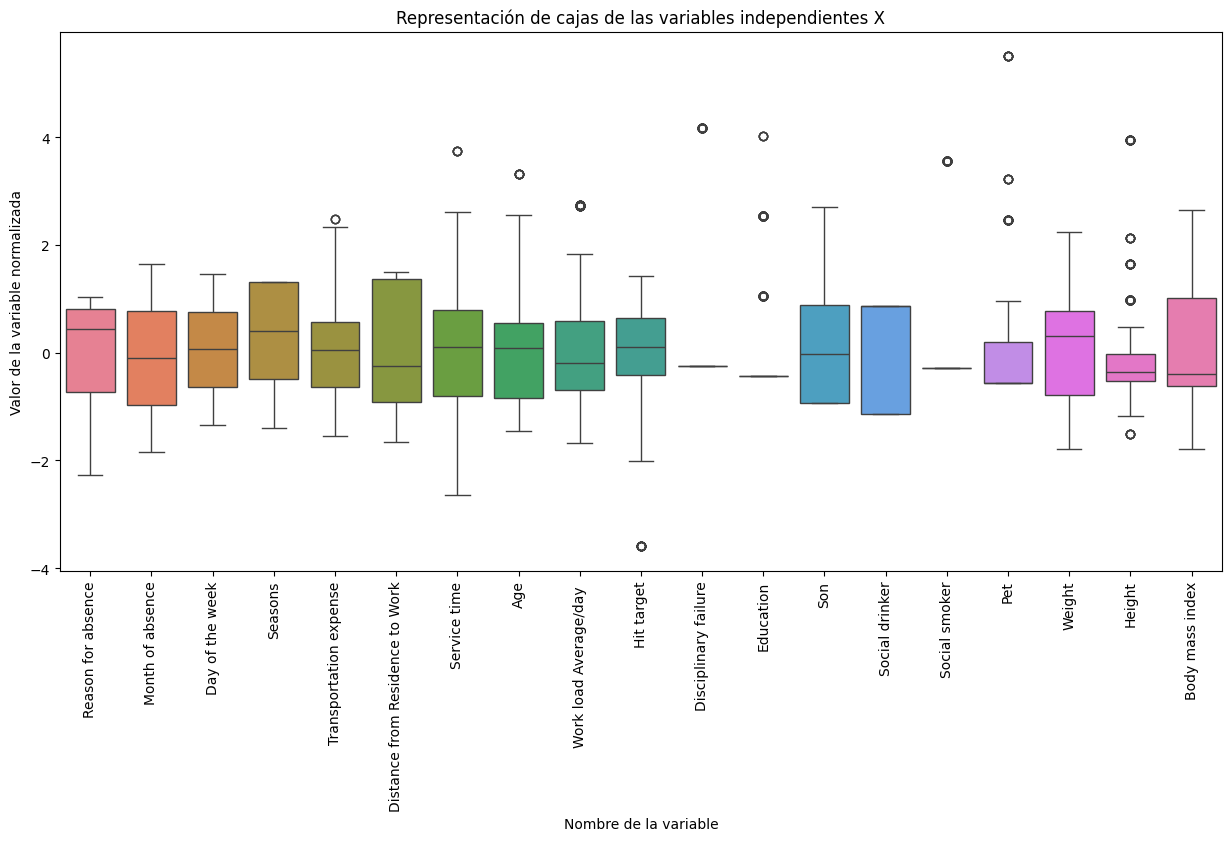

In [13]:
X_normalizado = (X-X.mean())/X.std()
plt.figure(figsize=(15,7))
ax = sns.boxplot(data=X_normalizado)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Representaci√≥n de cajas de las variables independientes X')
plt.ylabel('Valor de la variable normalizada')
_ = plt.xlabel('Nombre de la variable')

Escribe tus conclusiones sobre los boxplots.

### An√°lisis de Boxplots
Los boxplots nos permiten visualizar la distribuci√≥n de las variables y detectar posibles valores at√≠picos o patrones en los datos. A continuaci√≥n, detallo las observaciones clave:

1. Distribuci√≥n de las Variables
   
La mayor√≠a de las variables est√°n concentradas cerca de la media, con algunas mostrando mayor dispersi√≥n.
Variables como "Social drinker", "Social smoker" y "Son" son discretas y probablemente binarias o categ√≥ricas con pocos valores distintos.

Otras variables, como "Reason for absence" y "Distance from Residence to Work", muestran una mayor variabilidad, lo que indica diferencias importantes en los motivos de ausencia y la distancia que los empleados recorren para ir al trabajo.


2. Identificaci√≥n de Valores At√≠picos
Se observan outliers en m√∫ltiples variables, principalmente en:

"Transportation expense" ‚Üí Algunos empleados tienen costos de transporte significativamente m√°s altos que el promedio.
"Son", "Social drinker" y "Pet" ‚Üí Se presentan valores extremos, lo que sugiere que algunas personas tienen un n√∫mero inusualmente alto en estas variables.
"Weight" y "Body mass index" ‚Üí Existen empleados con pesos y niveles de IMC fuera del rango esperado, lo que podr√≠a ser relevante dependiendo del an√°lisis final.


3. Comparaci√≥n de Dispersi√≥n

Mayor dispersi√≥n:
"Transportation expense", "Distance from Residence to Work" y "Service time".
Esto indica diferencias significativas entre empleados en t√©rminos de gastos de transporte, distancia al trabajo y antig√ºedad en la empresa.

Menor dispersi√≥n:
"Hit target" ‚Üí La mayor√≠a de los empleados cumplen con los objetivos en un rango similar.
"Work load Average/day" ‚Üí La carga laboral diaria no var√≠a mucho entre los empleados.


4. Interpretaci√≥n General

Los valores at√≠picos detectados podr√≠an requerir un tratamiento adicional, dependiendo del enfoque que se quiera dar al an√°lisis (por ejemplo, eliminarlos, transformarlos o interpretarlos como casos especiales).

Algunas variables presentan baja variabilidad, lo que podr√≠a indicar que no aportan mucha informaci√≥n √∫til al modelo y podr√≠an ser descartadas en la fase de feature selection.

Otras, como "Distance from Residence to Work" o "Transportation expense", muestran diferencias significativas entre empleados y podr√≠an tener un impacto importante en el ausentismo.

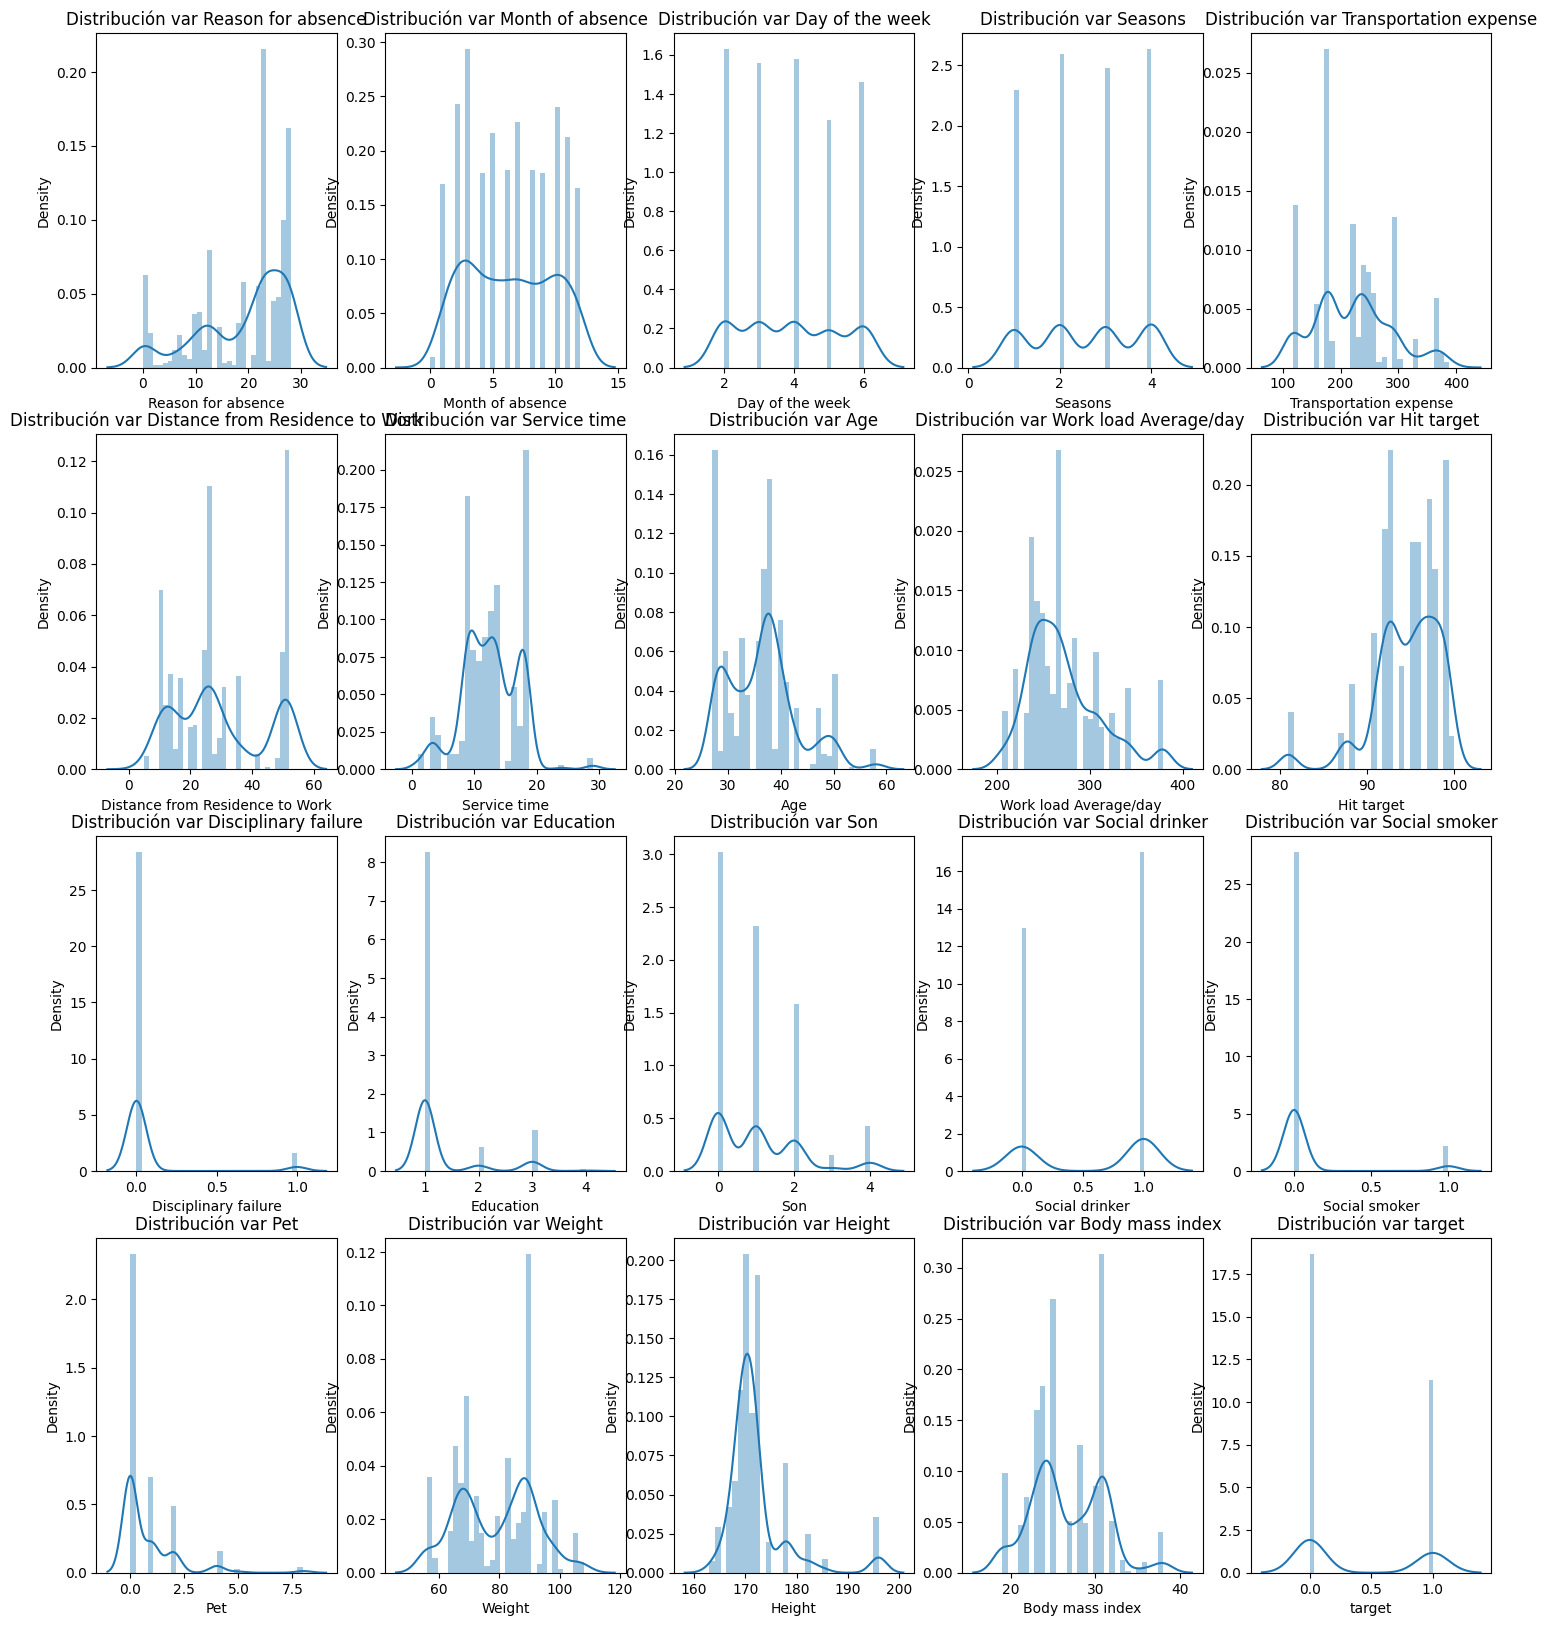

In [29]:
# Representa los histogramas de los datos completos, incluyendo la target
plt.figure(figsize=(18,20))
n = 0
for i, column in enumerate(XY.columns):
    n+=1
    plt.subplot(4, 5, n)
    sns.distplot(XY[column], bins=30)
    plt.title('Distribuci√≥n var {}'.format(column))
plt.show()

### **An√°lisis de Histogramas**  

Los histogramas nos muestran c√≥mo se distribuyen los datos y nos ayudan a detectar patrones clave:  

- **Variables con m√∫ltiples picos:**  
  - *"Reason for absence" y "Month of absence"* ‚Üí Hay ciertos motivos y meses donde las ausencias son m√°s frecuentes.  
  - *"Seasons" y "Day of the week"* ‚Üí Se nota que las ausencias tienden a concentrarse en ciertos d√≠as y estaciones.  

- **Variables sesgadas:**  
  - *"Service time" y "Age"* ‚Üí Hay m√°s empleados j√≥venes y con poca antig√ºedad.  
  - *"Body mass index"* ‚Üí Distribuci√≥n irregular, con varios grupos distintos.  

- **Variables binarias o categ√≥ricas:**  
  - *"Social drinker", "Social smoker", "Disciplinary failure"* ‚Üí La mayor√≠a de los empleados est√°n en una sola categor√≠a.  

- **Posibles valores at√≠picos:**  
  - *"Transportation expense" y "Weight"* ‚Üí Algunos empleados tienen gastos y pesos muy fuera del promedio.  

### **Conclusi√≥n**  
Hay patrones claros en las ausencias y algunos datos desbalanceados. Tambi√©n hay outliers en ciertas variables que podr√≠an necesitar limpieza.  

## Relaci√≥n variable vs target: 

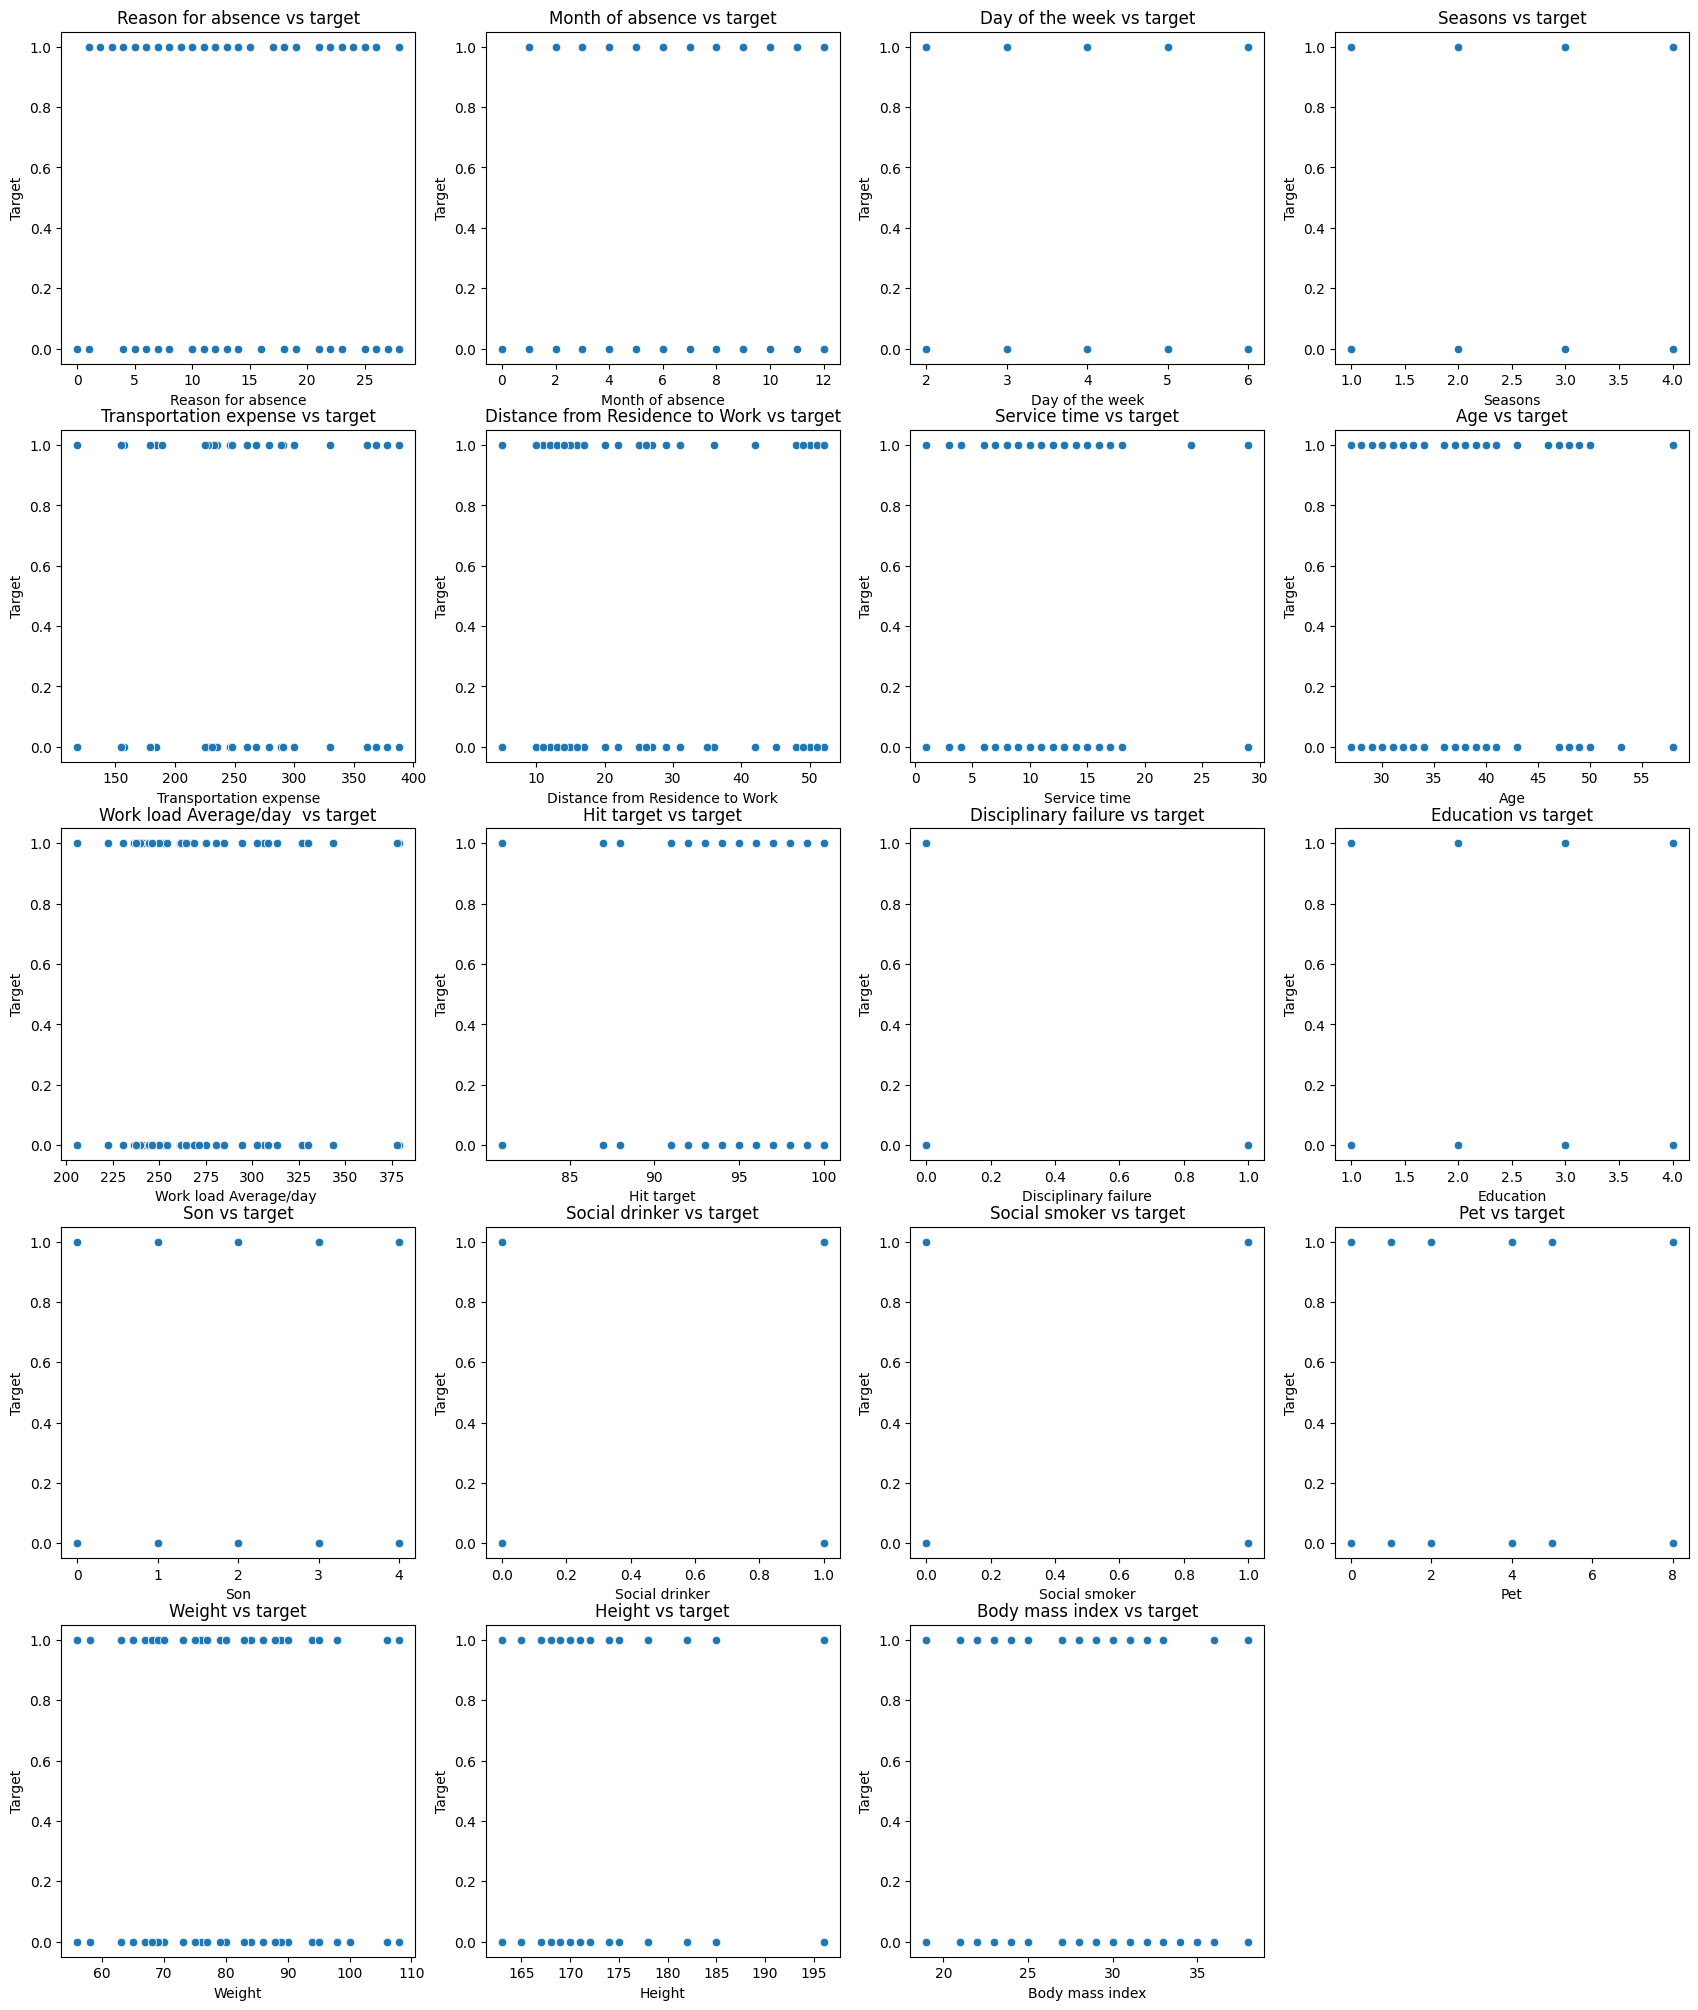

In [28]:
relaciones_vs_target(X, Y)

### Histogramas positivos-negativos

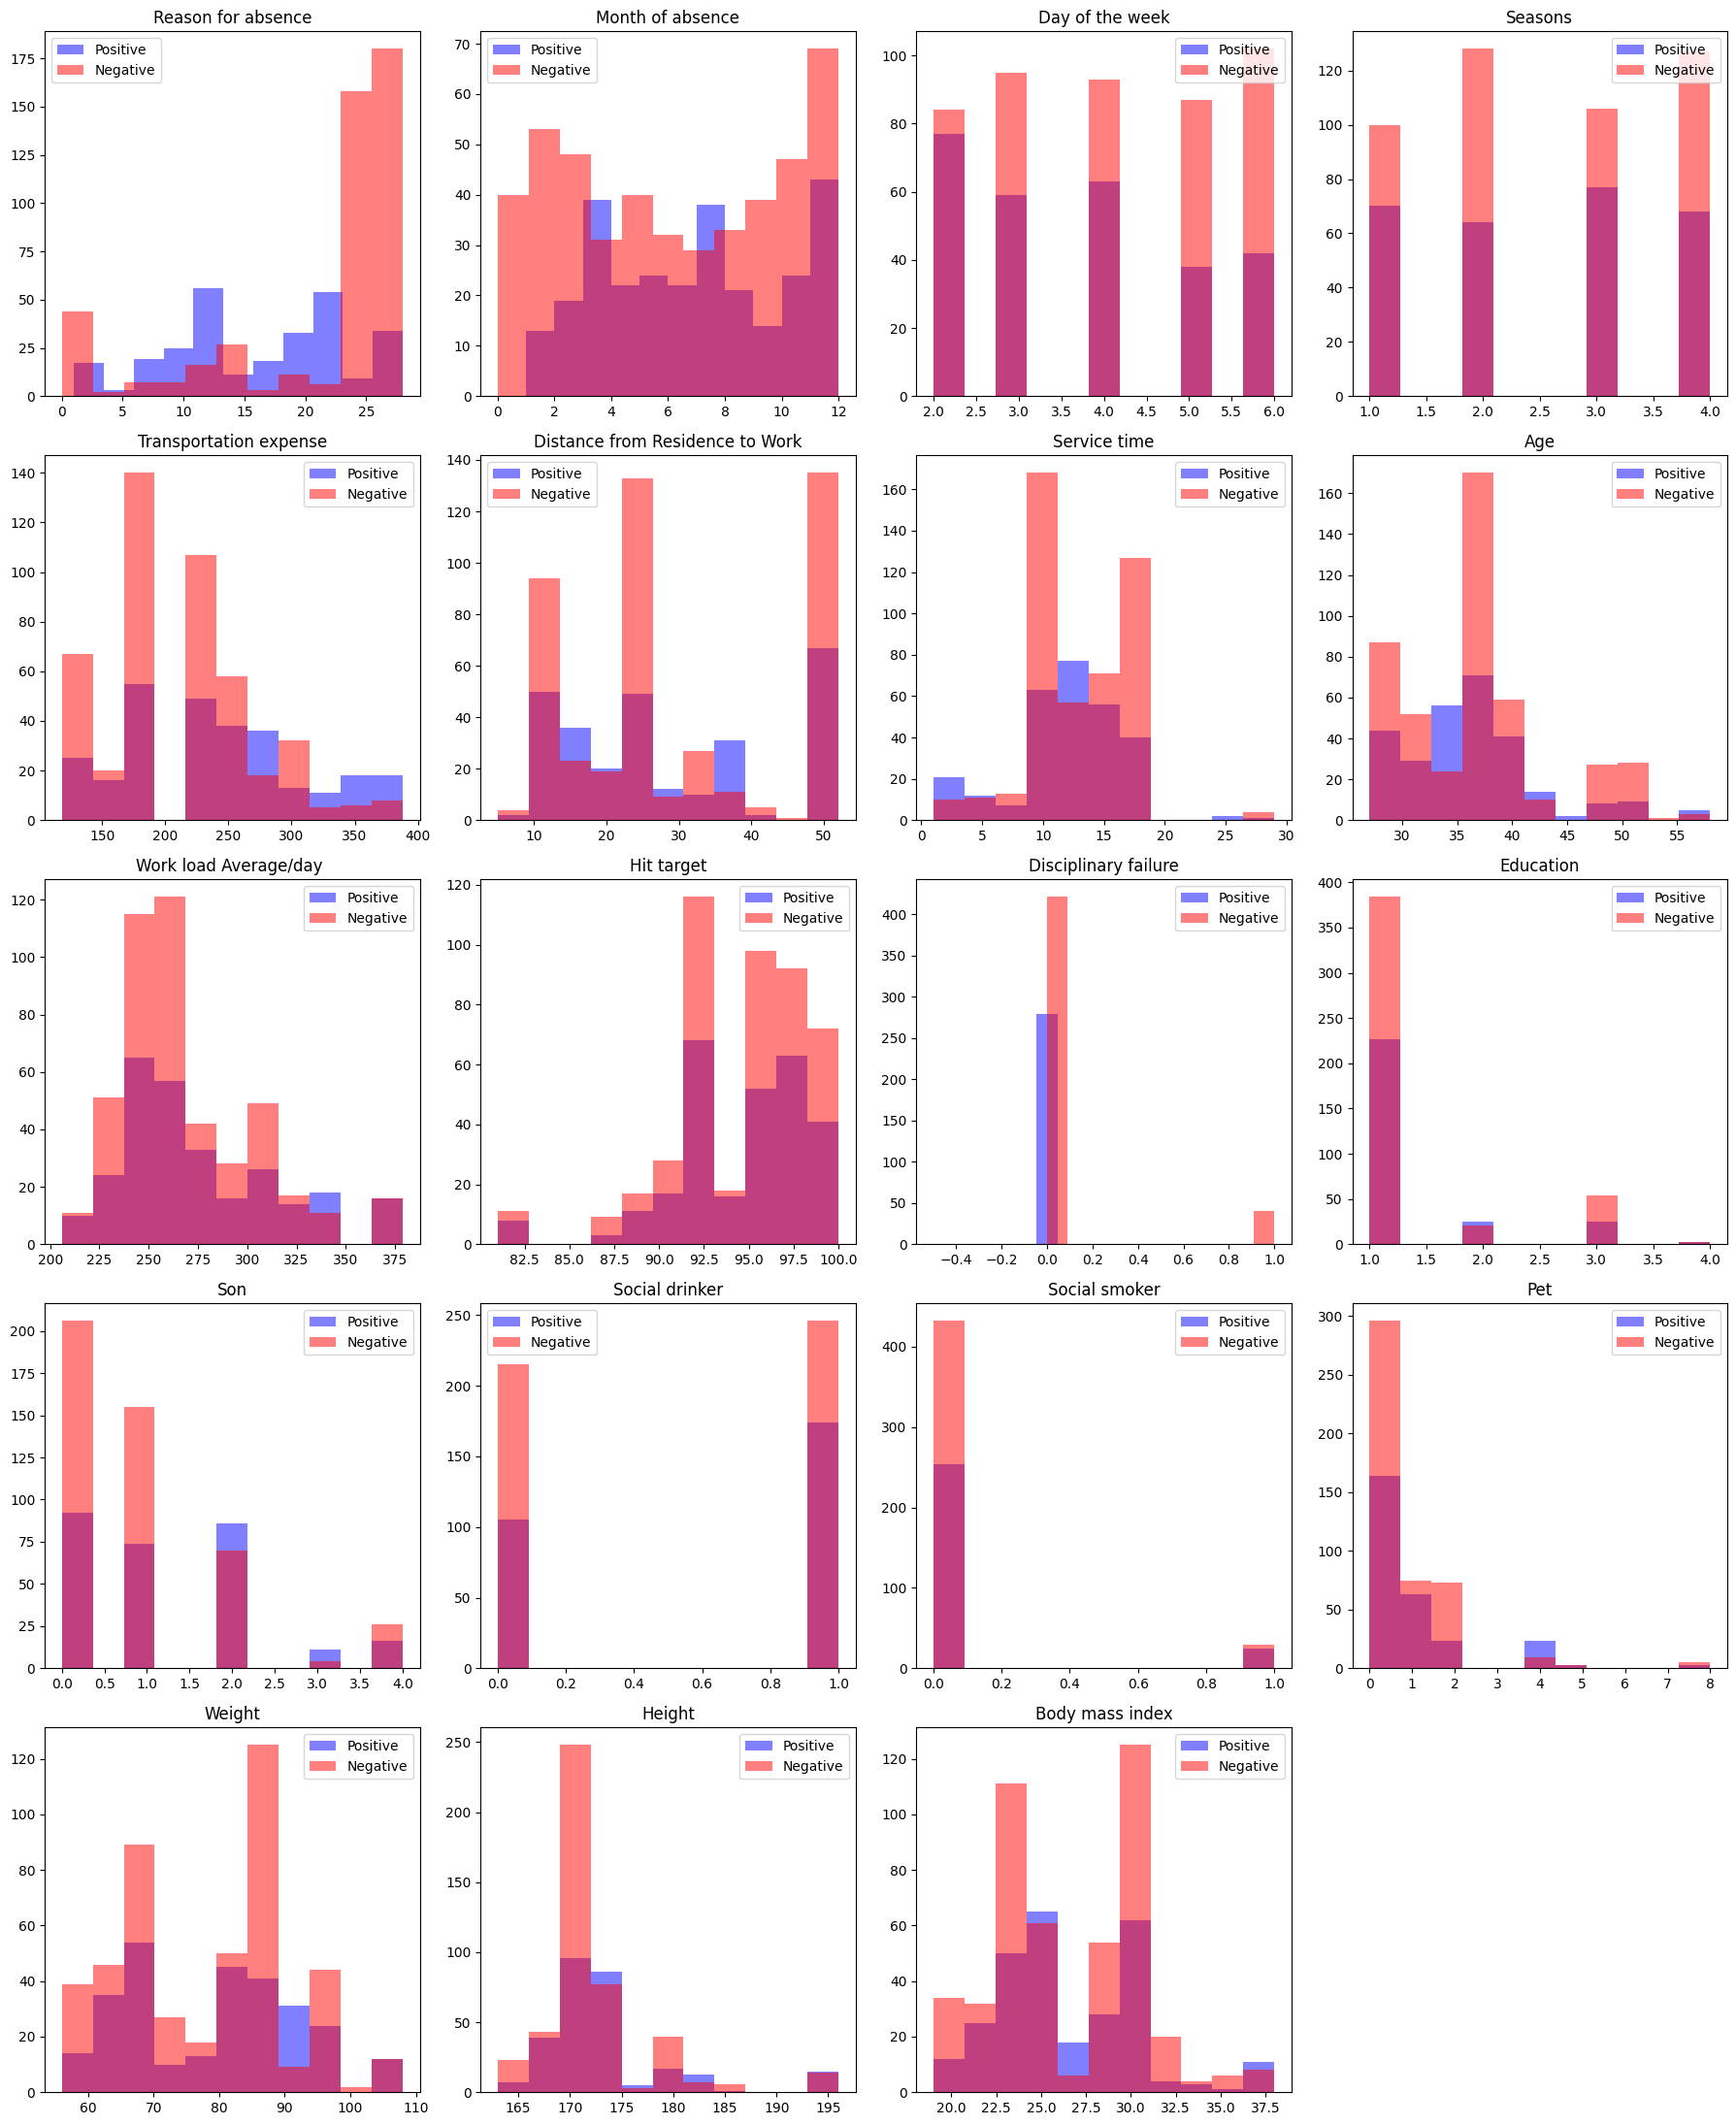

In [27]:
hist_pos_neg_feat(X,Y)

### **Comentario sobre los histogramas**  

Al analizar las distribuciones, algunas variables parecen tener m√°s potencial para diferenciar entre las clases:  

‚úÖ **Variables con mejor separaci√≥n:**  
- **Reason for absence:** Hay ciertas razones de ausencia donde una clase es claramente m√°s frecuente.  
- **Service time:** Se nota una diferencia en la distribuci√≥n, empleados con m√°s tiempo parecen estar m√°s ausentes.  
- **Age:** Hay m√°s personas mayores en la clase positiva, lo que sugiere que la edad puede influir en las ausencias.  

‚ö†Ô∏è **Variables con poca separaci√≥n:**  
- **Day of the week y Seasons:** Distribuciones casi id√©nticas en ambas clases, lo que indica que estos factores no parecen influir mucho.  
- **Education y Pet:** Casi no hay diferencia entre clases, probablemente irrelevantes para el modelo.  

### **Conclusi√≥n**  
Variables como **Reason for absence, Service time y Age** parecen ser m√°s √∫tiles para predecir ausencias, mientras que otras como **Education o Seasons** podr√≠an no aportar mucho valor. üöÄ

### Correlation matrix

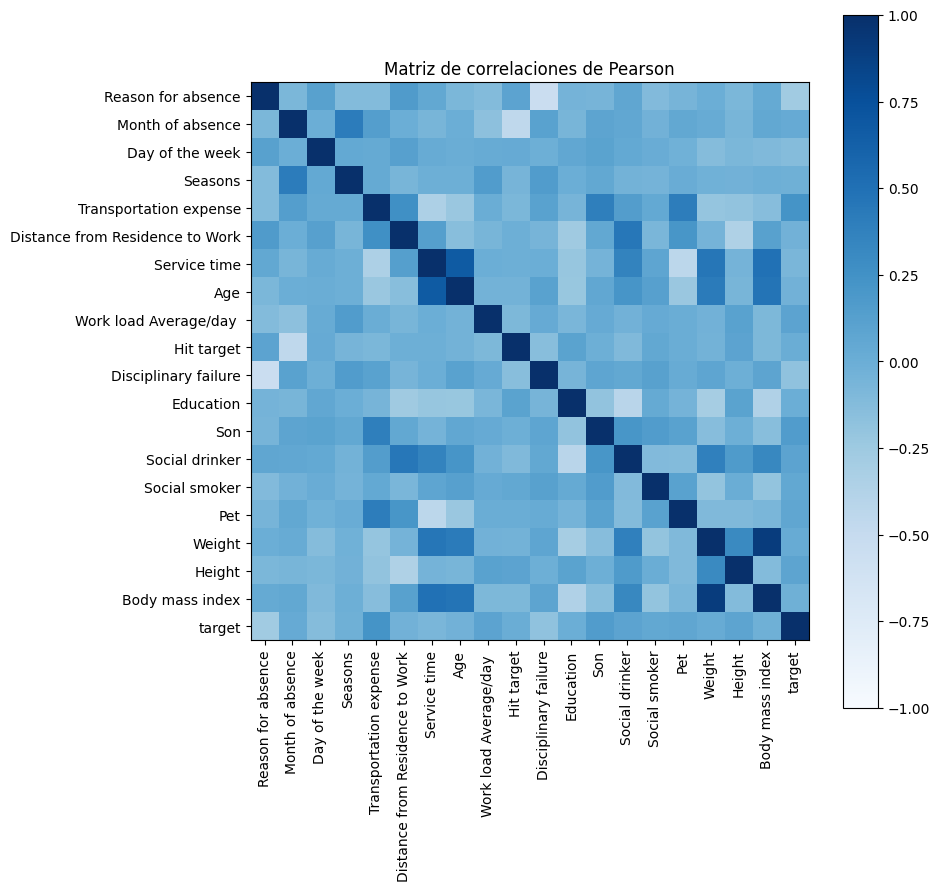

In [30]:
matriz_correlaciones = XY.corr(method='pearson')
n_ticks = len(XY.columns)
plt.figure( figsize=(9, 9) )
plt.xticks(range(n_ticks), XY.columns, rotation='vertical')
plt.yticks(range(n_ticks), XY.columns)
plt.colorbar(plt.imshow(matriz_correlaciones, interpolation='nearest', 
                            vmin=-1., vmax=1., 
                            cmap=plt.get_cmap('Blues')))
_ = plt.title('Matriz de correlaciones de Pearson')

## Variables con mayor correlaci√≥n con la target:

In [31]:
correlaciones_target = matriz_correlaciones.values[ -1, : -1]
indices_inversos =  abs(correlaciones_target[ : ]).argsort()[ : : -1]
diccionario = {}
for nombre, correlacion in zip( X.columns[indices_inversos], list(correlaciones_target[indices_inversos] ) ):
    diccionario[nombre] = correlacion
pd.DataFrame.from_dict(diccionario, orient='index', columns=['Correlaci√≥n con la target'])

Correlaci√≥n con la target
Reason for absence                               -0.273394
Transportation expense                            0.230672
Disciplinary failure                             -0.185966
Son                                               0.149157
Day of the week                                  -0.131982
Social drinker                                    0.088076
Work load Average/day                             0.086224
Height                                            0.079963
Service time                                     -0.076093
Pet                                               0.067480
Social smoker                                     0.049750
Distance from Residence to Work                  -0.035933
Age                                              -0.035552
Month of absence                                  0.027213
Seasons                                          -0.022440
Body mass index                                  -0.020764
Weight                                            0.019535
Hit target                                        0.005163
Education                                        -0.001815

### **An√°lisis de la Correlaci√≥n con la Target**  

 **Variables con mayor correlaci√≥n (m√°s predictivas linealmente):**  
- **Reason for absence (-0.27)** ‚Üí Tiene la correlaci√≥n m√°s fuerte (negativa), lo que sugiere que ciertos motivos de ausencia est√°n directamente relacionados con la target.  
- **Transportation expense (0.23)** ‚Üí Un mayor gasto en transporte parece estar asociado con la target, lo que puede indicar una relaci√≥n con la distancia o accesibilidad al trabajo.  
- **Disciplinary failure (-0.18)** ‚Üí Empleados con fallas disciplinarias tienden a estar menos ausentes, lo que puede deberse a medidas correctivas o despidos.  
- **Son (0.14)** ‚Üí Tener hijos parece estar asociado a una mayor probabilidad de ausencia.  

 **Variables con menor correlaci√≥n (poco predictivas linealmente):**  
- **Education (-0.0018)** ‚Üí Pr√°cticamente sin relaci√≥n con la target, por lo que no parece ser un factor relevante.  
- **Hit target (0.005)** ‚Üí La relaci√≥n con la target es m√≠nima, lo que indica que cumplir objetivos no est√° fuertemente ligado a la ausencia.  
- **Weight, BMI, Seasons, Month of absence** ‚Üí Correlaciones muy bajas, por lo que es poco probable que influyan directamente en la predicci√≥n.  

### **Conclusi√≥n**  
Las variables **Reason for absence, Transportation expense y Disciplinary failure** parecen ser las m√°s √∫tiles para predecir ausencias de manera lineal. Por otro lado, **Education, Hit target y Weight** probablemente no aporten mucho valor al modelo si se usa regresi√≥n lineal.

## Estandarizaci√≥n de los datos previa: 

In [32]:
obj_escalar = StandardScaler()
X_estandarizado = obj_escalar.fit_transform(X)

## Divisi√≥n en train y test: 

In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(X_estandarizado, Y, test_size=0.2, random_state=0)

## Aplica el modelo:

In [34]:
modelo = LogisticRegression()
modelo.fit(X_train, Y_train)

LogisticRegression()

In [35]:
y_test_pred_prob = modelo.predict_proba(X_test)
metrics.roc_auc_score(Y_test, y_test_pred_prob[:,1])

np.float64(0.8300653594771241)

## Optimiza los par√°metros:

In [36]:
modelo = LogisticRegression()
parametros = {"C": [0., 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08,0.09], 
              "class_weight":['balanced', None]}
modelo_gs = GridSearchCV(modelo, param_grid=parametros,
                         cv = 5, scoring='roc_auc')
modelo_gs.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07,
                               0.08, 0.09],
                         'class_weight': ['balanced', None]},
             scoring='roc_auc')

In [37]:
print(modelo_gs.best_params_, "\nROC AUC: {}".format(round(modelo_gs.best_score_,2)))

{'C': 0.07, 'class_weight': 'balanced'} 
ROC AUC: 0.81


In [38]:
df_search = pd.DataFrame.from_dict(modelo_gs.cv_results_)

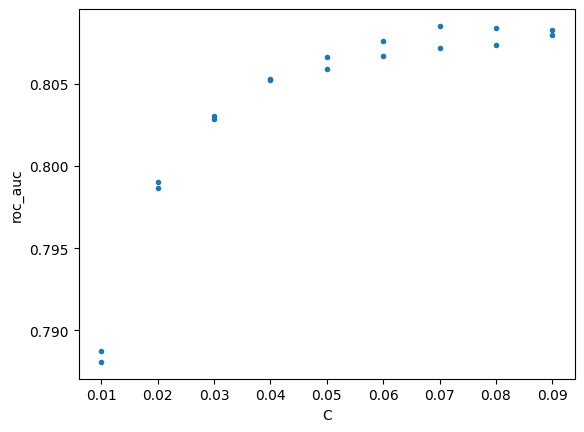

In [39]:
plt.xlabel('C')
plt.ylabel('roc_auc')
_ = plt.plot( df_search['param_C'], df_search['mean_test_score'], '.')

In [40]:
y_test_pred_prob = modelo_gs.predict_proba(X_test)
metrics.roc_auc_score(Y_test, y_test_pred_prob[:,1])

np.float64(0.8317460317460317)

## Representaci√≥n de las probabilidades

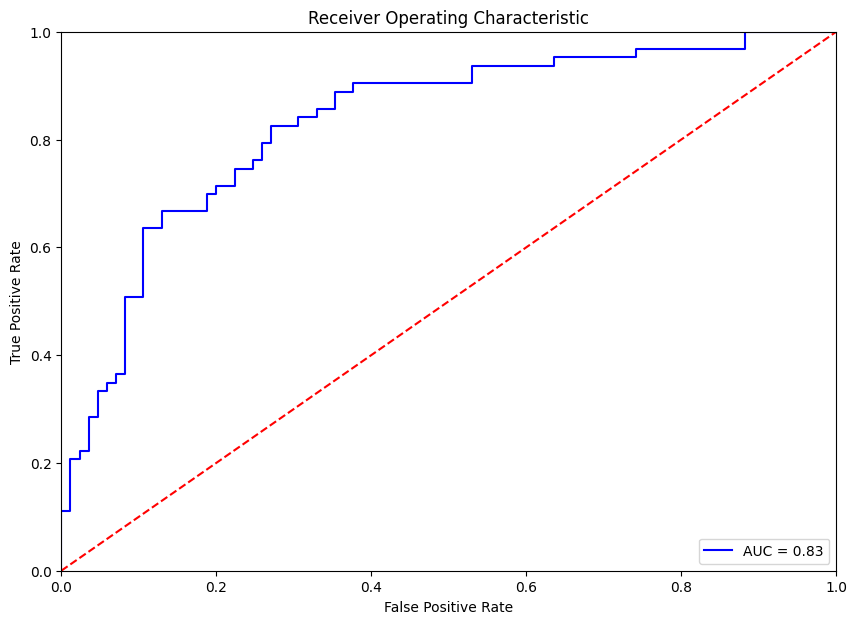

In [41]:
preds = y_test_pred_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

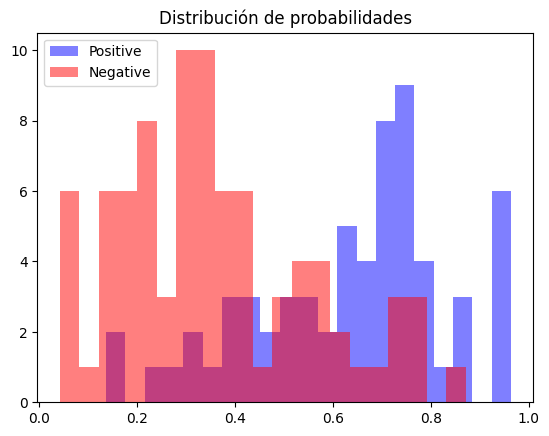

In [49]:
y_test_pred_prob = modelo_gs.predict_proba(X_test)
y_test_pred_prob_pos = y_test_pred_prob[np.where(Y_test == 1)[0]]
y_test_pred_prob_neg = y_test_pred_prob[np.where(Y_test == 0)[0]]

represento_doble_hist(y_test_pred_prob_pos[:, 1], y_test_pred_prob_neg[:, 1], nbins=21, density=False, title="Distribuci√≥n de probabilidades")

In [45]:
sensitividades = {}
for umbral in [0.1, 0.2, 0.3, 0.5, 0.6, 0.8]:
    y_umbralizadas = 1*(y_test_pred_prob[:, 1] > umbral)
    sensitividades[umbral] = metrics.recall_score(Y_test, y_umbralizadas)
sensitividades

{0.1: 1.0,
 0.2: 0.9682539682539683,
 0.3: 0.9365079365079365,
 0.5: 0.7619047619047619,
 0.6: 0.6507936507936508,
 0.8: 0.1746031746031746}

In [46]:
precisiones = {}
for umbral in [0.1, 0.2, 0.3, 0.5, 0.6, 0.8,0.9]:
    y_umbralizadas = 1*(y_test_pred_prob[:, 1] > umbral)
    precisiones[umbral] = metrics.precision_score(Y_test, y_umbralizadas)
precisiones

{0.1: 0.44366197183098594,
 0.2: 0.48031496062992124,
 0.3: 0.5514018691588785,
 0.5: 0.6956521739130435,
 0.6: 0.7884615384615384,
 0.8: 0.9166666666666666,
 0.9: 1.0}

In [48]:
y_umbralizadas = 1*(y_test_pred_prob[:, 1] > 0.5)
print("Matriz de confusi√≥n\n", metrics.confusion_matrix(Y_test, y_umbralizadas))
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(Y_test, y_umbralizadas),2)))  
print("Sensitividad\t{}".format(round(metrics.recall_score(Y_test, y_umbralizadas),2)))
print("Precisi√≥n\t{}".format(round(metrics.precision_score(Y_test, y_umbralizadas),2)))  

Matriz de confusi√≥n
 [[64 21]
 [15 48]]

Accuracy	0.76
Sensitividad	0.76
Precisi√≥n	0.7
